Follows from [single_exposure_modeling_wcython](single_exposure_modeling_wcython.ipynb) - see that and previous notebooks for more data exploration.

This notebook is a re-think of how to do the modeling.  Instead of summing along the PSF/LSF, try building a "model image" and then convolve that with the PSF/LSF. 

In [1]:
import os
import json
import collections
from pathlib import Path
from multiprocessing import Pool

import numpy as np
from scipy import interpolate, integrate, signal

from tqdm.notebook import tqdm

from astropy.coordinates import SkyCoord
from astropy import table
from astropy import convolution
from astropy import visualization
visualization.quantity_support()
from astropy import units as u
from astropy import constants
from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.nddata import StdDevUncertainty

import specutils
from specutils import manipulation as specman
from specutils import analysis as specan

from jwst import datamodels

import webbpsf

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
%load_ext Cython

In [3]:
data_dir = Path('widened_2')

test_path = list(data_dir.glob('*04101_00001_nrs2_cal.fits'))
assert len(test_path) == 1
test_path = test_path[0]

test_dm = datamodels.open(test_path)

example_slit = test_dm.slits[50]

## Load spectral model

In [4]:
phoenix_model = fits.open('lte03300-0.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
#phoenix_model = fits.open('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte03300-0.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits', cache=True)
phoenix_wave = fits.getdata('WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')*u.angstrom
#phoenix_wave = fits.getdata('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS//WAVE_PHOENIX-ACES-AGSS-COND-2011.fits', cache=True)*u.angstrom
phoenix_spec = specutils.Spectrum1D(spectral_axis=phoenix_wave, flux=phoenix_model[0].data*u.Unit(phoenix_model[0].header['BUNIT']))

2023-03-17 02:17:05,624 - stpipe - WARNING - /usr/local/lib/python3.11/site-packages/astropy/units/format/generic.py:604: UnitsWarning: 'erg/s/cm^2/cm' contains multiple slashes, which is discouraged by the FITS standard
  warnings.warn(



In [5]:
xg, yg = np.meshgrid(*[np.arange(s) for s in example_slit.data.shape[::-1]])

data_coo_mid, data_wl_mid = example_slit.meta.wcs.pixel_to_world(xg, yg)
data_coo_edges, data_wl_edges = example_slit.meta.wcs.pixel_to_world([xg-.5, xg-.5, xg+.5, xg+.5], 
                                                                     [yg-.5, yg+.5, yg+.5, yg-.5])
nanless_msk = np.all(np.isfinite(data_wl_edges), axis=0) & np.isfinite(data_wl_mid)
np.sum(nanless_msk)

18691

Lets make sure we understand the order of the arrays here:

In [6]:
data_coo_edges[0][nanless_msk].separation(data_coo_edges[1][nanless_msk])[:5]

<Angle [2.87034583e-05, 2.87034557e-05, 2.87034530e-05, 2.87034504e-05,
        2.87034477e-05] deg>

In [7]:
data_coo_edges[1][nanless_msk].separation(data_coo_edges[2][nanless_msk])[:5]

<Angle [7.28557665e-09, 7.47007245e-09, 7.65454808e-09, 7.83902389e-09,
        8.02349935e-09] deg>

In [8]:
data_coo_edges[2][nanless_msk].separation(data_coo_edges[3][nanless_msk])[:5]

<Angle [2.87034557e-05, 2.87034530e-05, 2.87034504e-05, 2.87034477e-05,
        2.87034449e-05] deg>

In [9]:
data_coo_edges[3][nanless_msk].separation(data_coo_edges[0][nanless_msk])[:5]

<Angle [7.28297084e-09, 7.46743506e-09, 7.65186783e-09, 7.83631010e-09,
        8.02075548e-09] deg>

In [10]:
data_coo_edges[0][nanless_msk].separation(data_coo_edges[2][nanless_msk])[:5]

<Angle [2.86961727e-05, 2.86959856e-05, 2.86957985e-05, 2.86956113e-05,
        2.86954242e-05] deg>

In [11]:
data_coo_edges[1][nanless_msk].separation(data_coo_edges[3][nanless_msk])[:5]

<Angle [2.87107413e-05, 2.87109231e-05, 2.87111049e-05, 2.87112867e-05,
        2.87114684e-05] deg>

So 1/2 and 0/3 are much closer than the other combinations. So x is indeed the dispersion direction

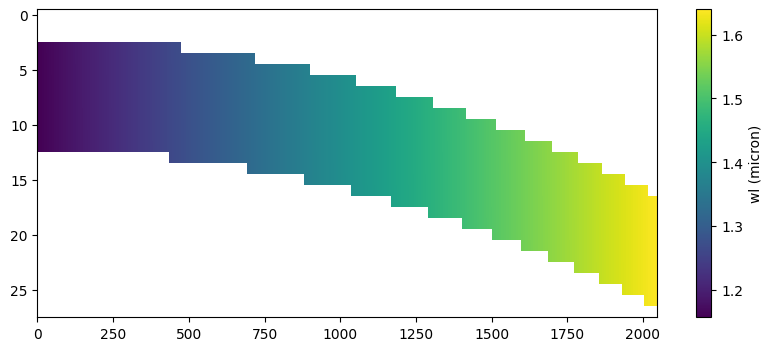

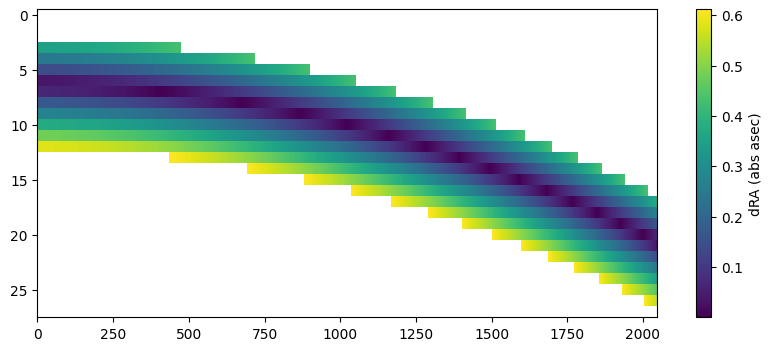

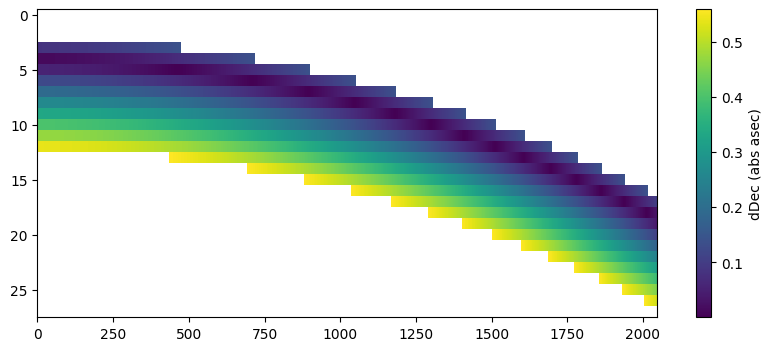

In [12]:
plt.figure(figsize=(10, 4))
plt.imshow(data_wl_mid.value, aspect='auto', interpolation='nearest')
plt.colorbar().set_label('wl (micron)')

plt.figure(figsize=(10, 4))
plt.imshow(np.abs(data_coo_mid.ra - example_slit.source_ra*u.deg).to(u.arcsec).value, aspect='auto', interpolation='nearest')
plt.colorbar().set_label('dRA (abs asec)')

plt.figure(figsize=(10, 4))
plt.imshow(np.abs(data_coo_mid.dec - example_slit.source_dec*u.deg).to(u.arcsec).value, aspect='auto', interpolation='nearest')
plt.colorbar().set_label('dDec (abs asec)')

The RA/Dec tracks are notably different.  Clearly showing the target is a bit off from expectations. So can we find the ra/dec locus that matches?

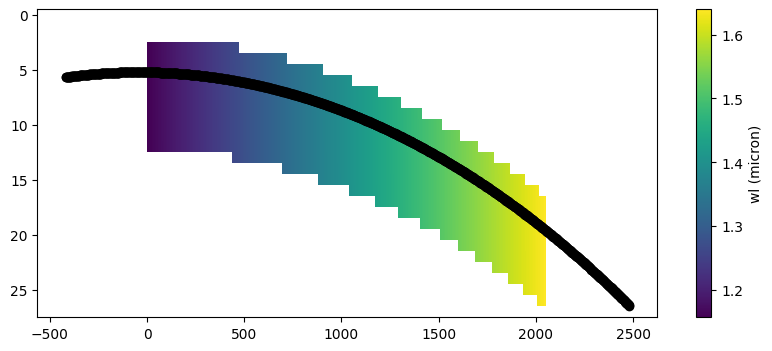

In [13]:
wls = np.linspace(np.nanmin(data_wl_mid)-.1*u.micron, np.nanmax(data_wl_mid)+.1*u.micron, 1024)
scs =  SkyCoord(example_slit.source_ra*np.ones(len(wls))*u.deg + 0.0*u.arcsec,  
                example_slit.source_dec*np.ones(len(wls))*u.deg + 0.0*u.arcsec)

x, y = example_slit.meta.wcs.world_to_pixel(scs, wls)
msk = ~(np.isnan(x)|np.isnan(y))



plt.figure(figsize=(10, 4))
plt.imshow(data_wl_mid.value, aspect='auto', interpolation='nearest')
plt.colorbar().set_label('wl (micron)')

plt.scatter(x[msk], y[msk], c='k');

So WCS will happily interpolate outside the range, but it also gives a nice locus. This suggests the following approach:

1. At each point on the locus using the model wavelength grid, drop a transpose of the PSF
2. Compute the overlap % of each PSF pixel to each image pixel
3. Multiply the % by the PSF
4. multiply by the model flux and add that into the sim image

Key question: can this be done fast enough? It needs to be recalculated every iteration because wl (i.e. redshift), or source position might change.  First test the spped of a single iteration of 2/3:

In [14]:
%%cython --annotate

import numpy as np
cimport cython

cdef double NaN = np.nan

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
def overlap_loop(double[::1] psf_lx, double[::1] psf_ux, double[::1] psf_ly, double[::1] psf_uy,
                 double[::1] data_lx, double[::1] data_ux, double[::1] data_ly, double[::1] data_uy,
                 double[::1] psf_flux, double[::1] data):
    """
    Assumptions: psf arrays all same length, data arrays all same length. data pre-initialized as 0 or NaN
    Also that PSF grid is smaller than data grid (i.e., result is "fraction of psf in data" not other way around), 
    data grid are size 1 - effectively the PSF is recast into "data coordinates".
    """
    
    cdef int n_psf = len(psf_flux)
    cdef int n_data = len(data)
    cdef int i, j
    cdef double overlap_width, overlap_height
    
    for i in range(n_psf):
        for j in range(n_data):
            if data[j] == NaN:
                continue
            overlap_width = min(psf_ux[i], data_ux[j]) - max(psf_lx[i], data_lx[j])
            overlap_height = min(psf_uy[i], data_uy[j]) - max(psf_ly[i], data_ly[j])
            if overlap_width > 0 and overlap_height > 0:
                data[j] += overlap_width*overlap_height*psf_flux[i]

The below are various setup steps, timed to get a sense of where bottlenecks might be in the loops

In [15]:
%%time

data_xedges, data_yedges = np.meshgrid(np.arange(example_slit.data.shape[1] + 1)-0.5, np.arange(example_slit.data.shape[0] + 1)-0.5)
data_xl = np.ascontiguousarray(data_yedges[:-1, :-1].ravel())
data_xu = np.ascontiguousarray(data_xedges[1:, 1:].ravel())
data_yl = np.ascontiguousarray(data_yedges[:-1, :-1].ravel())
data_yu = np.ascontiguousarray(data_xedges[1:, 1:].ravel())

CPU times: user 880 µs, sys: 180 µs, total: 1.06 ms
Wall time: 603 µs


In [16]:
%%time

datar = np.ascontiguousarray((data_wl_mid*0).ravel()) # this keeps the nan structure but sets everything else to 0

CPU times: user 333 µs, sys: 68 µs, total: 401 µs
Wall time: 247 µs


CPU times: user 6.07 s, sys: 3.92 s, total: 10 s
Wall time: 7.87 s


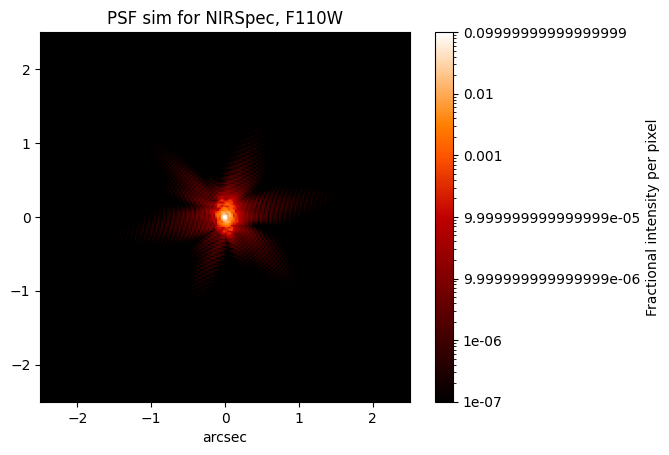

In [17]:
%%time

wns = webbpsf.NIRSpec()

wns.detector = 'NRS2'
wns.image_mask = 'Single MSA open shutter'

psf = wns.calc_psf(monochromatic=(1.4*u.micron).to(u.meter).value)
webbpsf.display_psf(psf)

In [41]:
%%time

psf_flux = psf['OVERDIST'].data
psfx_off_1d = (np.arange(psf_flux.shape[0]) - (psf_flux.shape[0]-1)/2)/psf['OVERDIST'].header['DET_SAMP']
psfy_off_1d = (np.arange(psf_flux.shape[1]) - (psf_flux.shape[1]-1)/2)/psf['OVERDIST'].header['DET_SAMP']

psfx_off, psfy_off = np.meshgrid(psfy_off_1d, psfx_off_1d)

CPU times: user 690 µs, sys: 220 µs, total: 910 µs
Wall time: 911 µs


For use below... what pixel encloses a certain fraction of the flux?

array([0.39528471, 0.95197164, 2.15783456, 2.48117916, 6.38601989])

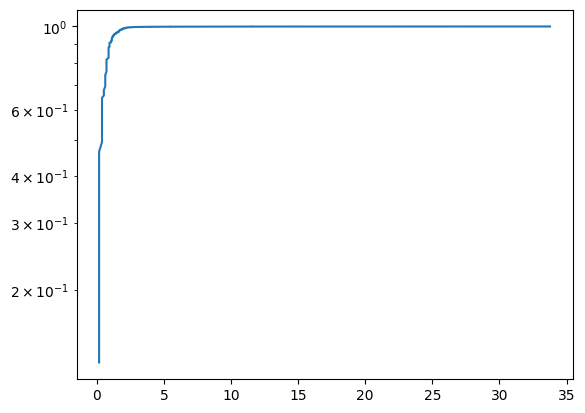

In [42]:
psf_rad = np.hypot(psfx_off, psfy_off)
sorti = np.argsort(psf_rad.ravel())
psfe = np.cumsum(psf_flux.ravel()[sorti])

plt.semilogy(psf_rad.ravel()[sorti], psfe/psfe[-1])
np.interp([.5, .9, .99, .995, .999], psfe/psfe[-1], psf_rad.ravel()[sorti]) # pixel count including 99.9% of the flux

In [43]:
%%time

x0, y0 = example_slit.meta.wcs.world_to_pixel(scs[512], wls[512])
x0, y0

CPU times: user 58.9 ms, sys: 29.7 ms, total: 88.5 ms
Wall time: 52.3 ms


(1017.7380095590206, 8.815566925552957)

In [44]:
%%time

psf_xl_off = psfx_off - 0.5/psf['OVERDIST'].header['DET_SAMP']
psf_xu_off = psfx_off + 0.5/psf['OVERDIST'].header['DET_SAMP']

psf_yl_off = psfy_off - 0.5/psf['OVERDIST'].header['DET_SAMP']
psf_yu_off = psfy_off + 0.5/psf['OVERDIST'].header['DET_SAMP']

CPU times: user 2.41 ms, sys: 0 ns, total: 2.41 ms
Wall time: 1.62 ms


In [54]:
%%time 

psf_radius = np.hypot((psf_xl_off + psf_xu_off)/2, (psf_yl_off + psf_yu_off)/2)
msk = psf_radius.ravel() < 3 # 99.7% or so of the flux

psf_xl = np.ascontiguousarray((x0 + psf_xl_off).ravel()[msk])
psf_xu = np.ascontiguousarray((x0 + psf_xu_off).ravel()[msk])
psf_yl = np.ascontiguousarray((y0 + psf_yl_off).ravel()[msk])
psf_yu = np.ascontiguousarray((y0 + psf_yu_off).ravel()[msk])
psf_fluxr = np.ascontiguousarray(psf_flux.ravel()[msk])

CPU times: user 1.33 ms, sys: 0 ns, total: 1.33 ms
Wall time: 1.16 ms


In [55]:
%%time 

overlap_loop(psf_xl, psf_xu, psf_yl, psf_yu,
             data_xl, data_xu, data_yl, data_yu,
             psf_fluxr, datar)

CPU times: user 34.9 ms, sys: 0 ns, total: 34.9 ms
Wall time: 35.1 ms


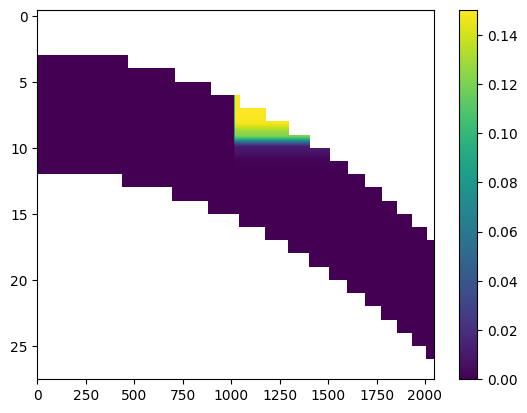

In [56]:
plt.imshow(datar.reshape(data_wl_mid.shape), aspect='auto')
plt.colorbar()

OK, a few ms per aint half bad at first glance, but we have to do this over the whole spectrum.  What happens if we assume we can index into the data array with some fidelity at least as good as the psf (which is conservative because the PSF is 4x oversampled)

In [57]:
%%time 

ndat = psf_fluxr.shape[0]//3 # should be 4 for oversampling, but 3 to be conservative in the indexing

overlap_loop(psf_xl, psf_xu, psf_yl, psf_yu,
             data_xl[:ndat], data_xu[:ndat], data_yl[:ndat], data_yu[:ndat],
             psf_fluxr, datar[:ndat])

CPU times: user 92 µs, sys: 29 µs, total: 121 µs
Wall time: 122 µs


In [58]:
msk = (np.nanmin(data_wl_mid) < phoenix_wave) & (phoenix_wave < np.nanmax(data_wl_mid))
np.sum(msk) * 92e-6

20.05462

Now lets see how the model resolution compares to the data since that might let us shrink this down.

In [31]:
(np.nanmean(np.diff(data_wl_mid))/np.diff(phoenix_wave[msk]).mean()).decompose()

<Quantity 106.50709181>

Ok, so if we sub-sample down to 10x pixel scale in the spectrum we can get to ~2 sec per iteration.  That might do it!